# Cats vs dogs. Transfer learning.
## A binary classifier (either cat or dog) is used.
## This shows how to use transfer learning
### Keras, VGG16 and VGG19 will be used

In [1]:
# Lets import some stuff
import tensorflow as tf
from skimage import io
from IPython.display import Image
from PIL import Image as PILImage
import pandas as pd

#from skimage.transform import resize
import matplotlib.pyplot as plt
from os import listdir
from os import mkdir
from skimage.io import imsave
import numpy as np
from sklearn.utils import shuffle
import sys
#import os
import cv2
import os.path

from keras.applications import vgg16, vgg19
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.initializers import TruncatedNormal
from keras import optimizers
from keras.models import load_model
from keras.callbacks import EarlyStopping, TensorBoard
from keras.preprocessing.image import ImageDataGenerator


%matplotlib inline

Using TensorFlow backend.


In [2]:
FLOYDHUB=True
if FLOYDHUB:
    OUTPUT_DIR = "/output/"
    DATA_DIR = "/input/"
    CLEANED_DATA_DIR = "/input/"
    CATS_DIR = "/input/train/cat/"
else:
    CATS_DIR = "data/train/"
    OUTPUT_DIR = "/tmp/"
    DATA_DIR = "data/"
    CLEANED_DATA_DIR = "data/cleaned/"



### Explore the dataset

The definition of kaggle dataset is 

"The training archive contains 25,000 images of dogs and cats. Train your algorithm on these files and predict the labels for test1.zip (1 = dog, 0 = cat)."

Notice! your direcory should look like this (once you have uncompressed the data)
```
.
├── cats-vs-dogs.ipynb
└── data
    └── train [25000 entries exceeds filelimit, not opening dir]
            ├── cat.2976.jpg
            ├── dog.2977.jpg
            ├── cat.2978.jpg
            ├── dog.2979.jpg
            ├── ...

```
Of course images named cat.xxx.jpg are cats and thesame goes for the ones started with dogs.

We will rearrange them into

```
.
├── cats-vs-dogs.ipynb
└── data
    └── train [25000 entries exceeds filelimit, not opening dir]
    |       └── dog
    |       |   ├── dog.2976.jpg
    |       |   ├── dog.2978.jpg
    |       |   ├── dog.2979.jpg
    |       |   ├── ...
    |       |
    |       └── cat
    |           ├── cat.2976.jpg
    |           ├── cat.2978.jpg
    |           ├── ...
    └── validation [25000 entries exceeds filelimit, not opening dir]
            └── dog
            |   ├── dog.2976.jpg
            |   ├── dog.2978.jpg
            |   ├── dog.2979.jpg
            |   ├── ...
            |
            └── cat
                ├── cat.2976.jpg
                ├── cat.2978.jpg
                ├── ...

```

Lets open a few images


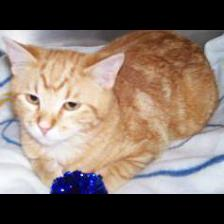

In [3]:
Image(filename=CATS_DIR+'cat.42.jpg')


In [4]:
IMAGE_WIDTH=224
IMAGE_HEIGHT=224
def resize_and_pad(img, size, padColor=0):
    # Credits goes to 
    # https://stackoverflow.com/questions/44720580/resize-image-canvas-to-maintain-square-aspect-ratio-in-python-opencv
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, 
                                    pad_left, pad_right, 
                                    borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

In [5]:
original = cv2.imread(CATS_DIR+'cat.42.jpg')
resized = resize_and_pad(original, (IMAGE_HEIGHT, IMAGE_WIDTH))
print(resized.shape)

(224, 224, 3)


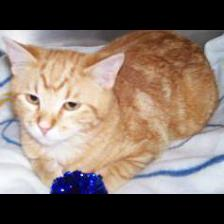

In [6]:
PILImage.fromarray(resized)

In [7]:
def convert_images(limit=None, data_dir=DATA_DIR, cleaned_data_dir=CLEANED_DATA_DIR):
    try:
        os.makedirs(cleaned_data_dir+"test/dog/")
        os.makedirs(cleaned_data_dir+"test/cat/")
        os.makedirs(cleaned_data_dir+"validation/dog/")
        os.makedirs(cleaned_data_dir+"validation/cat/")
        os.makedirs(cleaned_data_dir+"train/dog/")
        os.makedirs(cleaned_data_dir+"train/cat/")
        os.makedirs(cleaned_data_dir+"real_test/")
    except:
        print("Bummer!", cleaned_data_dir)
        pass
    
    
    current_set = "real_test/"
    for base_dir in ["test/", "train/"]:
        i = 1 # Represent the image index, as we have cats and dogs this goes between 0 to 12500
        print("Now checking dir", base_dir)
        for image_file in listdir(data_dir + base_dir):
            
            if ".jpg" in image_file:
                """
                Keras will need images in the train/ dir and in the validation/ dir.

                Also, we would need test/ images.

                As we are dealing with a total of 25000 images, we will split them in 80-10-10

                Keras will later require us to have a dir for each class of image, so we will save 
                images now into cat/ or dog/ dir depending on the image name
                """
                if base_dir == "test/":
                    real_test = True
                    if current_set != "real_test/":
                        print("Now writing REAL test images")
                    current_set = "real_test/"
                else:
                    real_test = False
                    if i == 1:
                        print("Now writing train images")
                        current_set = "train/"
                    if i == 25000*0.8: # Validation set starts after we have processed 80% of images
                        print("Now writing validation images")
                        current_set = "validation/"
                    if i == 25000*0.9: # Test set starts after we hace processed 90% of images
                        print("Now writing test images")
                        current_set = "test/"
                
                original_img_path = data_dir+base_dir+image_file
                #print(original_img_path)
                original = cv2.imread(original_img_path)

                transformed = resize_and_pad(original, (IMAGE_WIDTH, IMAGE_HEIGHT))
                if real_test:
                    final_file = cleaned_data_dir+current_set+image_file
                else:
                    final_file = cleaned_data_dir+current_set+"dog/"+image_file
                    if "cat" in image_file:
                        final_file = cleaned_data_dir+current_set+"cat/"+image_file
                
                imsave(final_file, transformed)
                
                if i % 500 == 0:
                    print("Converted ", i, " images so far...")
                i += 1
            if limit and i > limit:
                print("Break it!")
                break
    print("Done!")

In [8]:
if False:
    convert_images()

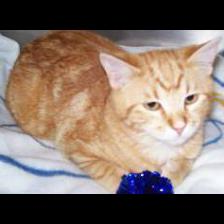

In [9]:
mirrored_image = cv2.flip(resized,1)
PILImage.fromarray(mirrored_image)

In [10]:
def augment_data():
    """
    This function is effectively deprecated, I is just here as an example, instead of this, we will use 
    kera's ImageDataGenerator instead
    """
    i = 0
    for image_file in listdir(CLEANED_DATA_DIR):
        original = cv2.imread(CLEANED_DATA_DIR + image_file)
        augmented_image = cv2.flip(original,1)
        final_file = CLEANED_DATA_DIR + image_file
        final_file = final_file.replace(".jpg", ".augmented.jpg")
        #print(final_file)
        imsave(final_file, augmented_image)
        i += 1
        if i % 250 == 0:
            print("Converted %d images so far..." % i)
if False:
    augment_data()

In [11]:
def build_model(pretrained_model, learning_rate=0.0001):
    
    # We do NOT want to retrain the convolutional layers from the pretrained model
    for layer in pretrained_model.layers:
        layer.trainable = False
    
    x = pretrained_model.output
    x = GlobalAveragePooling2D()(x)

    # add a fully-connected layer
    x = Dense(1024, activation='relu', kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=None))(x)

    # A dropout now
    x = Dropout(0.5)(x)

    # Another fully connected
    x = Dense(512, activation='relu', kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=None))(x)

    # Dropout again
    x = Dropout(0.5)(x)

    # and a fully connected output/classification layer
    predictions = Dense(2, 
                        activation='softmax', 
                        kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=None))(x)

    # create the full network so we can train on it
    my_model = Model(input=pretrained_model.input, output=predictions)
            
    adam = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)


    
    my_model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    
    return my_model

### Use VGG16 pretrained model

In [12]:
vgg16_model = build_model(vgg16.VGG16(weights='imagenet', include_top=False))
vgg19_model = build_model(vgg19.VGG19(weights='imagenet', include_top=False))

57810944/58889256 [============================>.] - ETA: 0s

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


79937536/80134624 [============================>.] - ETA: 0s

In [13]:
vgg19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### Using the image preprocessing tools from keras now.
 See https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [14]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for validation:
# only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255)

# and the same for the test set
test_datagen = ImageDataGenerator(rescale=1./255)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        CLEANED_DATA_DIR + '/train',  # this is the target directory
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use categorical_crossentropy loss, we will need one-hot-encoded...

# this is a similar generator, for validation data
validation_generator = validation_datagen.flow_from_directory(
        CLEANED_DATA_DIR + '/validation',
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=batch_size,
        class_mode='categorical')

# And the generator for test data
test_generator = test_datagen.flow_from_directory(
        CLEANED_DATA_DIR + '/test',
        target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
        batch_size=batch_size,
        class_mode='categorical')

Found 19999 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2501 images belonging to 2 classes.


### Now we will use a couple of callbacks

Essentially we will stop if the validation loss does not improve at least 0.001 units in 3 consecutive epochs. 

Also, we will log files to be used by tensorboard

In [15]:
early_stopping=EarlyStopping(monitor='val_loss', 
                             min_delta=0.001, 
                             patience=3, 
                             verbose=1, 
                             mode='auto')

tensorboard = TensorBoard(log_dir='./tensorboard-logs', 
                          histogram_freq=0, 
                          write_graph=True, 
                          write_images=True)

In [16]:
training_samples = 20000 # Remember, we use 80% of 25k images, so 25000 * 0.8 = 20000
validation_samples = 2500 # Remember we use 10% of 25k images so 25000 * 0.1 = 2500

test_samples = 2500
total_steps = test_samples // batch_size

#training_samples = 100 # Remember, we use 80% of 25k images, so 25000 * 0.8 = 20000
#validation_samples = 25 # Remember we use 10% of 25k images so 25000 * 0.1 = 2500

In [ ]:
vgg16_history = vgg16_model.fit_generator(train_generator,
                                          steps_per_epoch=training_samples // batch_size,
                                          epochs=10,
                                          callbacks=[early_stopping, tensorboard],
                                          validation_data=validation_generator,
                                          validation_steps=validation_samples // batch_size)

In [ ]:


vgg16_model.evaluate_generator(test_generator, steps=total_steps)

In [20]:
def plot_learning_curves(history):
    h = pd.DataFrame([history.history['acc'], history.history['val_acc']])
    h = h.T
    h.columns=['acc', 'val_acc']
    h.plot(figsize=(20, 5))
    plt.show()
    


In [ ]:
plot_learning_curves(vgg16_history)
MODEL_VGG16_FILE = "vgg16.model"
vgg16_model.save(MODEL_VGG16_FILE)

### Now, lets do the same with VGG19

In [17]:
vgg19_history = vgg19_model.fit_generator(train_generator,
                                          steps_per_epoch=training_samples // batch_size,
                                          epochs=12,
                                          callbacks=[early_stopping, tensorboard],
                                          validation_data=validation_generator,
                                          validation_steps=validation_samples // batch_size)

Epoch 1/12
1250/1250 [==============================] - 321s - loss: 0.5071 - acc: 0.7402 - val_loss: 0.2936 - val_acc: 0.8722
Epoch 2/12
1250/1250 [==============================] - 318s - loss: 0.3347 - acc: 0.8529 - val_loss: 0.2504 - val_acc: 0.8905
Epoch 3/12
1250/1250 [==============================] - 312s - loss: 0.3022 - acc: 0.8678 - val_loss: 0.2517 - val_acc: 0.8873
Epoch 4/12
1250/1250 [==============================] - 314s - loss: 0.2880 - acc: 0.8760 - val_loss: 0.2389 - val_acc: 0.8937
Epoch 5/12
1250/1250 [==============================] - 319s - loss: 0.2788 - acc: 0.8778 - val_loss: 0.2098 - val_acc: 0.9018
Epoch 6/12
1250/1250 [==============================] - 313s - loss: 0.2770 - acc: 0.8796 - val_loss: 0.2089 - val_acc: 0.9022
Epoch 7/12
1250/1250 [==============================] - 316s - loss: 0.2695 - acc: 0.8821 - val_loss: 0.2227 - val_acc: 0.8961
Epoch 8/12
1250/1250 [==============================] - 315s - loss: 0.2642 - acc: 0.8853 - val_loss: 0.2065 - 

In [18]:
vgg19_model.evaluate_generator(test_generator, steps=total_steps)


[0.19894790022562331, 0.90865384615384615]

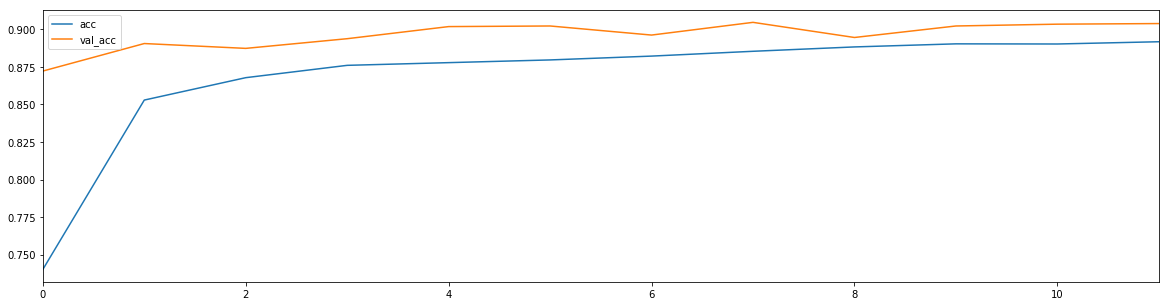

In [21]:
plot_learning_curves(vgg19_history)
MODEL_VGG19_FILE = "vgg19.model"
vgg19_model.save(MODEL_VGG19_FILE)

# Prediction area!!
## We will just load the keras model and use it to predict data

In [22]:
def calculate_value(cat, dog):
    if dog > cat:
        return dog
    else:
        return 1 - cat


def predict(my_model, output_file):
    REAL_TEST_IMAGES_DIR = CLEANED_DATA_DIR + "real_test/"
    real_test_images = []
    i = 0
    final_predictions = pd.DataFrame(columns=['cat', 'dog'])
    for i in range(1, 12501):     
        raw_image = io.imread(REAL_TEST_IMAGES_DIR + str(i) + ".jpg")
        real_test_images.append(raw_image)
        i+=1    
        if i % 2500 == 0:
            print("Loaded", i, "images so far...")
    X = np.array(real_test_images)
    X = X / 255
    print("Done!") 
    predictions = my_model.predict(X, verbose=1)
    final_predictions = final_predictions.append(pd.DataFrame(predictions, columns=['cat', 'dog']))

    final_predictions['final'] = final_predictions.apply(lambda row: calculate_value(row['cat'],row['dog']),axis=1)

    results = pd.DataFrame(final_predictions['final'])
    results.head()
    results['id'] = results.index + 1
    results['label'] = results['final']
    results.head()
    results.to_csv(OUTPUT_DIR+"/"+output_file, index=False, columns=['id', 'label'])
    return final_predictions


In [ ]:
vgg16_model = load_model(MODEL_VGG16_FILE)
output = predict(vgg16_model, "vgg16Prediction.csv")

In [23]:
vgg19_model = load_model(MODEL_VGG19_FILE)
output = predict(vgg19_model, "vgg19Prediction.csv")

Loaded 2500 images so far...
Loaded 5000 images so far...
Loaded 7500 images so far...
Loaded 10000 images so far...
Loaded 12500 images so far...
Done!
12500/12500 [==============================] - 176s   


In [24]:
output.head()

,cat,dog,final
0,0.069799,0.930201,0.930201
1,0.000020,0.999980,0.999980
2,0.000090,0.999910,0.999910
3,0.004029,0.995971,0.995971
4,0.996425,0.003575,0.003575
